In [1]:
#Problem Setup/Definition:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.prediction_algorithms import predictions
from surprise.model_selection import cross_validate, KFold, train_test_split
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise import KNNWithMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


In [2]:
##################################
## Import Movie Ratings Dataset ##
##################################
rawMovieData = pd.read_csv('../input/ratings.csv')
# Use suprise  Dataset Library: https://surprise.readthedocs.io/en/stable/dataset.html
# Reader Class: https://surprise.readthedocs.io/en/stable/reader.html
# Defaults are set to: user, item, rating
reader = Reader()
movieRatingsDataset = Dataset.load_from_df(rawMovieData[['userId', 'movieId', 'rating']], reader)
movieRatingsDataFrame = movieRatingsDataset.df
movieRatingsListTuples = movieRatingsDataset.raw_ratings

## Question 35

Answer in report

## Question 36

In [3]:
# Drop any users that have less than ratings than 'numberRecommend'
# Drop any users that have no ratings above the 'threshold' (They dont like anything)
def RemoveUsers(testdataset, threshold, numberRecommend):
    
    allUserDataMap = defaultdict(list)
    
    # dataTuple: (UserID, movieID, true_rating)
    # Create a Mapping of 'userID':[[movieId, trueRating],...]
    for dataTuple in testdataset:
        
        userID = dataTuple[0]
        movieID = dataTuple[1]
        trueRating = dataTuple[2]
        
        allUserDataMap[str(userID)].append([movieID, trueRating])
        
    ################################################################
    # Drop users who havent rated enough movies 'numberRecommend' ##
    ################################################################
    
    print("# Users BEFORE trim: " + str(len(allUserDataMap)))
    allUserDataMap = {userId:moveList for userId, moveList in allUserDataMap.items() if len(moveList) >= numberRecommend}
    print("# Users after trim (Less than " + str(numberRecommend) + " movies rated): " + str(len(allUserDataMap)))

    #####################################################
    # Drop users who have no ratings above 'threshold' ##
    #####################################################
    # Create list of users that need to be deleted.
    deleteList = []
    for users, movieList in allUserDataMap.items():
        likedCounter = 0
        # Iterate over all movies rated by a specific user
        for movie in range(len(movieList)):
            # Check if 'trueRating' > threshhold, increment 'likedCounter'
            if movieList[movie][1] > threshold:
                likedCounter += 1
        
        # If total number of 'likedCounter' movies = 0, add to deleteList
        if likedCounter == 0:
            deleteList.append(users)
    
    # Delete all users on 'deleteList'
    for deleteUsers in deleteList:
        del allUserDataMap[deleteUsers]
    
    print("# Users after trim (zero ratings above " + str(threshold) + "): " + str(len(allUserDataMap)))
    
    #######################################
    # Convert back to testdataset format ##
    #######################################
    trimmedTestDataSet = []
    
    # Iterate over all entries in dictionary, convert to list of tuples
    for users, movieList in allUserDataMap.items():
        for movies in range(len(movieList)):
            
            # Defined testDataSet Tuple entries (userId, movieId, rating)
            userId = int(users)
            movieId = movieList[movies][0]
            rating = movieList[movies][1]
            dataTuple = (userId, movieId, rating)
            
            # append each item into final tuple()-list[]
            trimmedTestDataSet.append(dataTuple)
    
    return trimmedTestDataSet

In [4]:
def PrecisionRecall(predictionList, threshold, numberRecommend):
    
    # defaultdict is like a dictionary{} with built in key values (No Key Errors)
    userPredictionMap = defaultdict(list)
    userPrecisionList = []
    userRecallList = []
    
    # Calculate relevant movies (per user)
    # Dictionary{'userId':[estimated_rating, true_rating]}
    # predictionObjects: uid=userId, iid=movieId, r_ui=true_rating, est=predicted_rating, details={'was_impossible': False}
    for predictionObject in predictionList:
        
        # Break down predictionObject() into individual values 
        userID = predictionObject.uid
        predictedRating = predictionObject.est
        trueRating = predictionObject.r_ui

        # Hashmap of 'userId' :[[predictedRating, trueRating],...]
        userPredictionMap[str(userID)].append([predictedRating,trueRating])
    
        # Sort the predicted movies for each user in descending order
        for users, movieList in userPredictionMap.items():
            
            # users: <string> userId
            # movieList: <list> [[predictedRating, trueRating],...] 
            
            # Sort the movieList of each user in place (high-Low)
            movieList.sort(key=lambda movie: movie[0], reverse=True)

    ##############################
    # Calculate 'True Positives'##
    ##############################

    # Iterate over each userId
    for users, movieList in userPredictionMap.items():
 
        ###############################################################
        # Calculate S(t) Interect G: Number of items rated correctly ##
        ###############################################################

        # Iterate over each movie list [estimated_rating, true_rating] belonging to that userId
        # Only take up to the size of the recommendation list 'numberRecommend'
        truePositiveRecs = 0
        for movies in range(numberRecommend):
            # Count number of movies each userId has rated above the threshold (real_rating)
            if movieList[movies][1] >= threshold:
                    truePositiveRecs += 1
    
        ################################################
        # Calculate S(t): Number of recommended items ##
        ################################################

        numberRecommend = numberRecommend
    
        ########################################################
        # Calculate G: Number of true_ratings above threshold ##
        ########################################################

        trueRatingsAboveThreshold = 0
        # Iterate over each movie list [estimated_rating, true_rating] belonging to that userId
        # count number of movies that the user actually rates (true_rating) above threshold.
        for movies in range(len(movieList)):
            if movieList[movies][1] >= threshold:
                trueRatingsAboveThreshold += 1

        #################################
        # Calculate Precision & Recall ##
        #################################

        userPrecision = truePositiveRecs/numberRecommend
        userRecall = truePositiveRecs/trueRatingsAboveThreshold
    
        userPrecisionList.append(userPrecision)
        userRecallList.append(userRecall)
        
#        print("This user's precision: " + str(userPrecision))
#        print("This user's recall: " + str(userRecall))

        
    # Calculate the average precision/recall over ALL users in this testset.
    avgPrecision = np.mean(userPrecisionList)
    avgRecall = np.mean(userRecallList)
    
#    print("Average precision over all users: " + str(avgPrecision))
#    print("Average recall over all users: " + str(avgRecall))

    return avgPrecision, avgRecall
    

In [5]:
def SweepPrecisionRecall(model, k_fold, mthreshold): 
    # Define t values: Top rankings
    tRank = list(range(1,26))

    # Accuracy and Recall
    avgPrecisionList = []
    avgRecallList= []

    # Iterate over all 25 ranking values
    for rankValue in tRank:

        precisionList10 = []
        recallList10 = []
        kFoldCounter = 1
        # Assuming we need 10 Fold cross validation
        for traindataset, testdataset in KFold(n_splits=k_fold).split(movieRatingsDataset):

            # Train the Model
            model.fit(traindataset)

            # Trim testdataset
            trimmedTestDataset = RemoveUsers(testdataset, threshold=mthreshold, numberRecommend=rankValue)

            # Make Predictions
            predictionObjectList = model.test(trimmedTestDataset)

            # Calculate Precision/Recall
            precision, recall = PrecisionRecall(predictionObjectList, threshold=mthreshold, numberRecommend=rankValue)

            # Store the calculated precision & recall
            precisionList10.append(precision)
            recallList10.append(recall)

            # Print intermediate results
            print("The calculated Precision in this K-Fold run " + str(kFoldCounter) + "/10: " + str(precision))
            print("The calculated Recall in this K-Fold run " + str(kFoldCounter) + "/10: " + str(recall))
            print("\n"+"="*40+"\n")
            kFoldCounter += 1

        # Average recall/precision over the 10 K-fold runs. 
        # Append to averageList[]
        avgPrecisionList.append(np.mean(precisionList10))
        avgRecallList.append(np.mean(recallList10))
        print("The Average Precision in this t_value run " + str(rankValue) + "/25: " + str(np.mean(precisionList10)))
        print("The Average Recall in this t_value run " + str(rankValue) + "/25: " + str(np.mean(recallList10)))
        print("\n"+"="*40+"\n")
    
    return avgPrecisionList, avgRecallList


In [6]:
#################
## KNN RANKING ##
#################
# Define KNN Model: K_value from Question 11 = 24
k=24
knnSimilarities = {'name':'pearson', 'user_based':True}
knnModel = KNNWithMeans(k=k, sim_options=knnSimilarities)

knnPrecisionList, knnRecallList = SweepPrecisionRecall(model=knnModel, k_fold=10, mthreshold=3)

Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 602
# Users after trim (Less than 1 movies rated): 602
# Users after trim (zero ratings above 3): 567
The calculated Precision in this K-Fold run 1/10: 0.9435626102292769
The calculated Recall in this K-Fold run 1/10: 0.20945638868561384


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 598
# Users after trim (Less than 1 movies rated): 598
# Users after trim (zero ratings above 3): 563
The calculated Precision in this K-Fold run 2/10: 0.9342806394316163
The calculated Recall in this K-Fold run 2/10: 0.2044665098964677


Computing the pearson similarity matrix...
Done computing similarity matrix.
# Users BEFORE trim: 596
# Users after trim (Less than 1 movies rated): 596
# Users after trim (zero ratings above 3): 555
The calculated Precision in this K-Fold run 3/10: 0.9333333333333333
The calculated Recall in this K-Fold run 3/10: 0.2177770

Average Precision over 10-Folds:
Threshold: 1/25: 0.9346667388607918
Threshold: 2/25: 0.9248908158386151
Threshold: 3/25: 0.9163383742186311
Threshold: 4/25: 0.9167337135978005
Threshold: 5/25: 0.9126614823803836
Threshold: 6/25: 0.9095993962831848
Threshold: 7/25: 0.9065135296144368
Threshold: 8/25: 0.9061123170666411
Threshold: 9/25: 0.902080965737295
Threshold: 10/25: 0.8998018879583498
Threshold: 11/25: 0.9012571169809569
Threshold: 12/25: 0.8995483702378546
Threshold: 13/25: 0.8991703315971569
Threshold: 14/25: 0.8966996508606412
Threshold: 15/25: 0.8975277652711149
Threshold: 16/25: 0.8945249270181602
Threshold: 17/25: 0.8942575015806792
Threshold: 18/25: 0.8913186976256805
Threshold: 19/25: 0.8894932363234929
Threshold: 20/25: 0.8878523663594414
Threshold: 21/25: 0.8881481142969785
Threshold: 22/25: 0.8848395538599675
Threshold: 23/25: 0.8830406056560038
Threshold: 24/25: 0.8818122206932199
Threshold: 25/25: 0.8785142001862276


Text(0, 0.5, 'Precision over 10 K-folds')

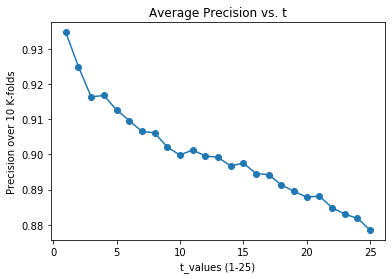

In [7]:
#######################
## KNN Precision Plot #
#######################
print("Average Precision over 10-Folds:")
for prec in range(len(knnPrecisionList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(knnPrecisionList[prec]))

t_value = range(1,26)
plt.plot(t_value, knnPrecisionList, marker='o')
plt.title("Average Precision vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Precision over 10 K-folds")

Average Recall over 10-Folds:
Threshold: 1/25: 0.20853567535457343
Threshold: 2/25: 0.3369092783041754
Threshold: 3/25: 0.4135811215198791
Threshold: 4/25: 0.4495185919667268
Threshold: 5/25: 0.4724974367343804
Threshold: 6/25: 0.4850206708322237
Threshold: 7/25: 0.4970403989017031
Threshold: 8/25: 0.5066799734185807
Threshold: 9/25: 0.5223637710791716
Threshold: 10/25: 0.5355646362201463
Threshold: 11/25: 0.5455189892178405
Threshold: 12/25: 0.5467930194568377
Threshold: 13/25: 0.5542893754496603
Threshold: 14/25: 0.5662746372323614
Threshold: 15/25: 0.5674057306835084
Threshold: 16/25: 0.5764227623101565
Threshold: 17/25: 0.5809608378194433
Threshold: 18/25: 0.5834403208465191
Threshold: 19/25: 0.5915248273437663
Threshold: 20/25: 0.595544447682846
Threshold: 21/25: 0.60351212300215
Threshold: 22/25: 0.5998342256207699
Threshold: 23/25: 0.6097761836679649
Threshold: 24/25: 0.6111111490813037
Threshold: 25/25: 0.6150462816941782


Text(0, 0.5, 'Recall over 10 K-folds')

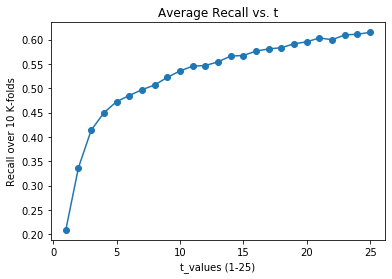

In [8]:
####################
## KNN Recall Plot #
####################
print("Average Recall over 10-Folds:")
for prec in range(len(knnRecallList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(knnRecallList[prec]))

t_value = range(1,26)
plt.plot(t_value, knnRecallList, marker='o')
plt.title("Average Recall vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Recall over 10 K-folds")

Knn Precision vs. Recall over 10-Folds:


Text(0, 0.5, 'Precision')

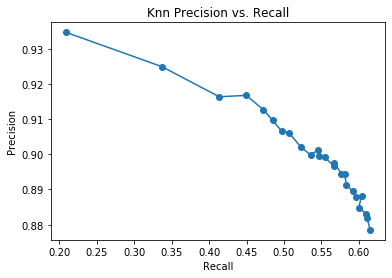

In [9]:
##################################
## KNN Prceision vs. Recall Plot #
##################################
print("Knn Precision vs. Recall over 10-Folds:")

t_value = range(1,26)
plt.plot(knnRecallList,knnPrecisionList,  marker='o')
plt.title("Knn Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

## Question 37

In [10]:
#################
## NMF RANKING ##
#################
# Define NMF Model: K_value from Question 18 = 14
k=14
nmfModel = NMF(n_factors=k)
nmfPrecisionList, nmfRecallList = SweepPrecisionRecall(model=nmfModel, k_fold=10, mthreshold=3)

# Users BEFORE trim: 598
# Users after trim (Less than 1 movies rated): 598
# Users after trim (zero ratings above 3): 558
The calculated Precision in this K-Fold run 1/10: 0.9336917562724014
The calculated Recall in this K-Fold run 1/10: 0.19180357331678827


# Users BEFORE trim: 593
# Users after trim (Less than 1 movies rated): 593
# Users after trim (zero ratings above 3): 565
The calculated Precision in this K-Fold run 2/10: 0.9327433628318584
The calculated Recall in this K-Fold run 2/10: 0.2008684724576805


# Users BEFORE trim: 598
# Users after trim (Less than 1 movies rated): 598
# Users after trim (zero ratings above 3): 563
The calculated Precision in this K-Fold run 3/10: 0.9307282415630551
The calculated Recall in this K-Fold run 3/10: 0.1991581637424311


# Users BEFORE trim: 602
# Users after trim (Less than 1 movies rated): 602
# Users after trim (zero ratings above 3): 566
The calculated Precision in this K-Fold run 4/10: 0.9522968197879859
The calculated Recall in th

Average Precision over 10-Folds:
Threshold: 1/25: 0.9328083117777339
Threshold: 2/25: 0.9150612272790404
Threshold: 3/25: 0.9120046897619541
Threshold: 4/25: 0.9104675716854065
Threshold: 5/25: 0.9073729433938856
Threshold: 6/25: 0.9049530025064264
Threshold: 7/25: 0.9017260483434797
Threshold: 8/25: 0.8993138514607548
Threshold: 9/25: 0.8962639761138401
Threshold: 10/25: 0.8986130569073568
Threshold: 11/25: 0.897315913321634
Threshold: 12/25: 0.8942461361330569
Threshold: 13/25: 0.8960661263726015
Threshold: 14/25: 0.8948537281370903
Threshold: 15/25: 0.8921711639590176
Threshold: 16/25: 0.8903850551661758
Threshold: 17/25: 0.8893844618705685
Threshold: 18/25: 0.8882140689914356
Threshold: 19/25: 0.8866371582153743
Threshold: 20/25: 0.886340622858088
Threshold: 21/25: 0.8839743069445959
Threshold: 22/25: 0.8821633355034576
Threshold: 23/25: 0.8809943601212936
Threshold: 24/25: 0.8800807705900413
Threshold: 25/25: 0.8758758493047549


Text(0, 0.5, 'Precision over 10 K-folds')

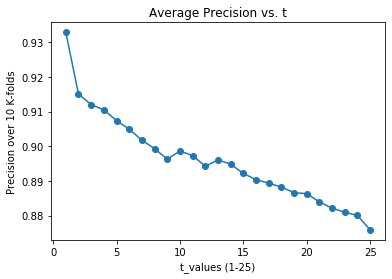

In [11]:
#######################
## NMF Precision Plot #
#######################
print("Average Precision over 10-Folds:")
for prec in range(len(nmfPrecisionList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(nmfPrecisionList[prec]))

t_value = range(1,26)
plt.plot(t_value, nmfPrecisionList, marker='o')
plt.title("Average Precision vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Precision over 10 K-folds")

Average Recall over 10-Folds:
Threshold: 1/25: 0.2033649158843458
Threshold: 2/25: 0.33486022840222773
Threshold: 3/25: 0.4048593731921827
Threshold: 4/25: 0.44777966040178174
Threshold: 5/25: 0.46577595792229687
Threshold: 6/25: 0.4812992954693004
Threshold: 7/25: 0.4921395840388919
Threshold: 8/25: 0.5028509098382941
Threshold: 9/25: 0.5163960857755373
Threshold: 10/25: 0.5285157750773054
Threshold: 11/25: 0.5362236557706762
Threshold: 12/25: 0.5469128281630324
Threshold: 13/25: 0.5526217470007382
Threshold: 14/25: 0.5612299681960546
Threshold: 15/25: 0.5696111299799907
Threshold: 16/25: 0.5717895460106767
Threshold: 17/25: 0.5757466189661071
Threshold: 18/25: 0.5857916930829484
Threshold: 19/25: 0.5887446762845696
Threshold: 20/25: 0.5951189920626331
Threshold: 21/25: 0.5988009440173112
Threshold: 22/25: 0.6021872116151885
Threshold: 23/25: 0.6042292465435315
Threshold: 24/25: 0.6064467729164816
Threshold: 25/25: 0.6151309331774002


Text(0, 0.5, 'Recall over 10 K-folds')

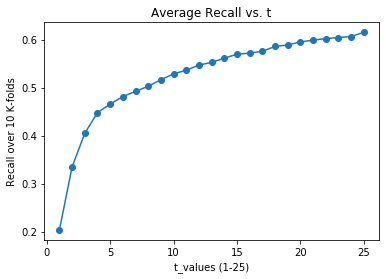

In [12]:
####################
## NMF Recall Plot #
####################
print("Average Recall over 10-Folds:")
for prec in range(len(nmfRecallList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(nmfRecallList[prec]))

t_value = range(1,26)
plt.plot(t_value, nmfRecallList, marker='o')
plt.title("Average Recall vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Recall over 10 K-folds")

NNMF Precision vs. Recall over 10-Folds:


Text(0, 0.5, 'Precision')

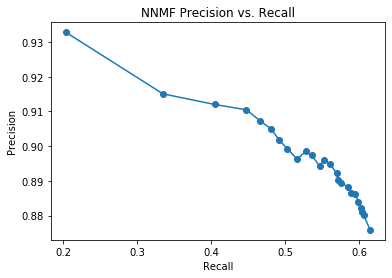

In [13]:
##################################
## NNMF Prceision vs. Recall Plot #
##################################
print("NNMF Precision vs. Recall over 10-Folds:")

t_value = range(1,26)
plt.plot(nmfRecallList,nmfPrecisionList, marker='o')
plt.title("NNMF Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

## Question 38

In [14]:
#####################
## MF-Bias RANKING ##
#####################
# Define MF-Bias Model: K_value from Question 25 = 40
k=40
svdModel = SVD(n_factors=k, biased=True)
svdPrecisionList, svdRecallList = SweepPrecisionRecall(model=svdModel, k_fold=10, mthreshold=3)

# Users BEFORE trim: 599
# Users after trim (Less than 1 movies rated): 599
# Users after trim (zero ratings above 3): 572
The calculated Precision in this K-Fold run 1/10: 0.9388111888111889
The calculated Recall in this K-Fold run 1/10: 0.21453501699300306


# Users BEFORE trim: 596
# Users after trim (Less than 1 movies rated): 596
# Users after trim (zero ratings above 3): 571
The calculated Precision in this K-Fold run 2/10: 0.9176882661996497
The calculated Recall in this K-Fold run 2/10: 0.2041981110703779


# Users BEFORE trim: 593
# Users after trim (Less than 1 movies rated): 593
# Users after trim (zero ratings above 3): 566
The calculated Precision in this K-Fold run 3/10: 0.9452296819787986
The calculated Recall in this K-Fold run 3/10: 0.20956979864175945


# Users BEFORE trim: 592
# Users after trim (Less than 1 movies rated): 592
# Users after trim (zero ratings above 3): 558
The calculated Precision in this K-Fold run 4/10: 0.9336917562724014
The calculated Recall in t

Average Precision over 10-Folds:
Threshold: 1/25: 0.9403252390770384
Threshold: 2/25: 0.9303027099899326
Threshold: 3/25: 0.923878364928387
Threshold: 4/25: 0.9160098003629793
Threshold: 5/25: 0.914685297318399
Threshold: 6/25: 0.91275481754304
Threshold: 7/25: 0.9084590132111666
Threshold: 8/25: 0.9077181008366839
Threshold: 9/25: 0.9089056795326871
Threshold: 10/25: 0.9062603342252322
Threshold: 11/25: 0.9023348082517326
Threshold: 12/25: 0.9018803422669995
Threshold: 13/25: 0.8984196659812795
Threshold: 14/25: 0.8996209847116319
Threshold: 15/25: 0.902104407558587
Threshold: 16/25: 0.8978937265300129
Threshold: 17/25: 0.8962551113339426
Threshold: 18/25: 0.8939223439340249
Threshold: 19/25: 0.8954261865959106
Threshold: 20/25: 0.8950608311679703
Threshold: 21/25: 0.88934747535101
Threshold: 22/25: 0.891176375946557
Threshold: 23/25: 0.8879618537786372
Threshold: 24/25: 0.8890704446271043
Threshold: 25/25: 0.8826889285820874


Text(0, 0.5, 'Precision over 10 K-folds')

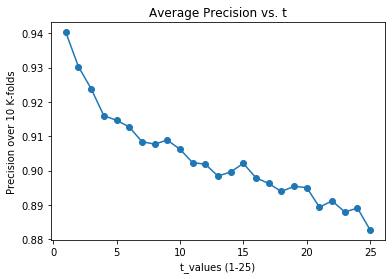

In [15]:
###########################
## MF-Bias Precision Plot #
###########################
print("Average Precision over 10-Folds:")
for prec in range(len(svdPrecisionList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(svdPrecisionList[prec]))

t_value = range(1,26)
plt.plot(t_value, svdPrecisionList, marker='o')
plt.title("Average Precision vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Precision over 10 K-folds")

Average Recall over 10-Folds:
Threshold: 1/25: 0.20879486991231425
Threshold: 2/25: 0.33041079014388697
Threshold: 3/25: 0.40647963663893494
Threshold: 4/25: 0.4520528378215669
Threshold: 5/25: 0.47029522126808515
Threshold: 6/25: 0.48161724509808285
Threshold: 7/25: 0.4933396174820743
Threshold: 8/25: 0.5145858262001674
Threshold: 9/25: 0.5242113154979642
Threshold: 10/25: 0.5323078954475979
Threshold: 11/25: 0.5400102081609282
Threshold: 12/25: 0.5533072355159071
Threshold: 13/25: 0.556202645160431
Threshold: 14/25: 0.5655519395335835
Threshold: 15/25: 0.5623242300692347
Threshold: 16/25: 0.5676905469400019
Threshold: 17/25: 0.5817798966233355
Threshold: 18/25: 0.5886692600454293
Threshold: 19/25: 0.5858609954335143
Threshold: 20/25: 0.5957822452652284
Threshold: 21/25: 0.6015514682478752
Threshold: 22/25: 0.606116000917287
Threshold: 23/25: 0.611647960841033
Threshold: 24/25: 0.6151105732780646
Threshold: 25/25: 0.6220816862146421


Text(0, 0.5, 'Recall over 10 K-folds')

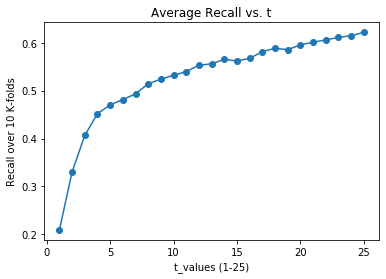

In [16]:
###########################
## MF-Bias Precision Plot #
###########################
print("Average Recall over 10-Folds:")
for prec in range(len(svdRecallList)):
    print("Threshold: " + str(prec+1) + "/25: " + str(svdRecallList[prec]))

t_value = range(1,26)
plt.plot(t_value, svdRecallList, marker='o')
plt.title("Average Recall vs. t")
plt.xlabel("t_values (1-25)")
plt.ylabel("Recall over 10 K-folds")

MF-Bias Precision vs. Recall over 10-Folds:


Text(0, 0.5, 'Precision')

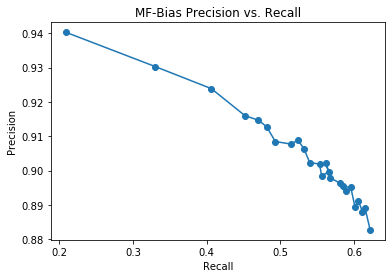

In [17]:
##################################
## MF-Bias Prceision vs. Recall Plot #
##################################
print("MF-Bias Precision vs. Recall over 10-Folds:")

t_value = range(1,26)
plt.plot(svdRecallList, svdPrecisionList, marker='o')
plt.title("MF-Bias Precision vs. Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

## Question 39

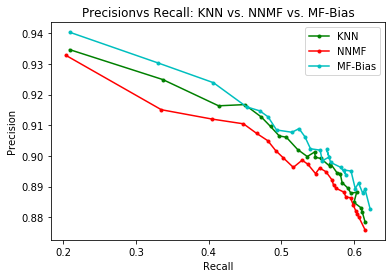

In [18]:
#############################################
## Plot All 3  Models: Precision vs. Recall #
#############################################
plt.plot(knnRecallList, knnPrecisionList, color='g', marker='o', markersize=3, label='KNN')
plt.plot(nmfRecallList, nmfPrecisionList, color='r', marker='o',  markersize=3, label='NNMF')
plt.plot(svdRecallList, svdPrecisionList, color='c', marker='o',  markersize=3, label='MF-Bias')
plt.title("Precisionvs Recall: KNN vs. NNMF vs. MF-Bias")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

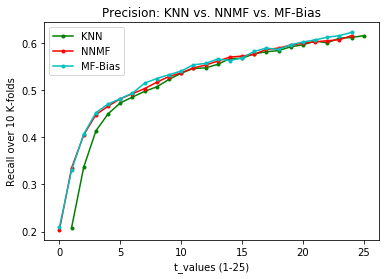

In [19]:
###############################
## Plot All 3  Models: Recall #
###############################
t_value = range(1,26)
plt.plot(t_value, knnRecallList, color='g', marker='o', markersize=3, label='KNN')
plt.plot(nmfRecallList, color='r', marker='o', markersize=3, label='NNMF')
plt.plot(svdRecallList, color='c', marker='o', markersize=3, label='MF-Bias')
plt.title("Precision: KNN vs. NNMF vs. MF-Bias")
plt.xlabel("t_values (1-25)")
plt.ylabel("Recall over 10 K-folds")
plt.legend()

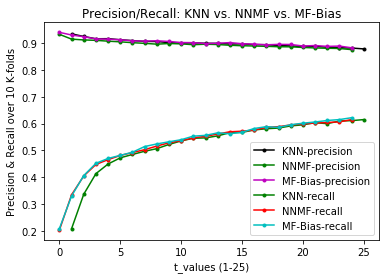

In [20]:
###########################################
## Plot All 3  Models: Precision + Recall #
###########################################
t_value = range(1,26)
plt.plot(t_value, knnPrecisionList, color='k', marker='o', markersize=3, label='KNN-precision')
plt.plot(nmfPrecisionList, color='g', marker='o',  markersize=3, label='NNMF-precision')
plt.plot(svdPrecisionList, color='m', marker='o',  markersize=3, label='MF-Bias-precision')
plt.plot(t_value, knnRecallList, color='g', marker='o', markersize=3, label='KNN-recall')
plt.plot(nmfRecallList, color='r', marker='o', markersize=3, label='NNMF-recall')
plt.plot(svdRecallList, color='c', marker='o', markersize=3, label='MF-Bias-recall')
plt.title("Precision/Recall: KNN vs. NNMF vs. MF-Bias")
plt.xlabel("t_values (1-25)")
plt.ylabel("Precision & Recall over 10 K-folds")
plt.legend()

In [21]:
#comment